In [1]:
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import folium
import numpy as np
import seaborn as sn
from shapely.geometry import Point
from IPython.display import Image
from statsmodels.tsa.seasonal import seasonal_decompose

plt.style.use('ggplot')

In [2]:
# Connect to Oracle
eng = nivapy.da.connect()

Connection successful.


# MARTINI - identify river input datasets

The marine models used in MARTINI require terrestrial inputs from the major rivers draining to Skagerrak. This notebook explores various different river chemistry datasets to see what's available.

Requirements for the data have been outlined by Phil (see e-mail received 19.09.2018 at 20.14):

 * Annual, monthly and daily nutrient concentrations in $mmol/m^3$. We are mostly interested in daily values, but monthly or even annual estimates could be used initially
 
 * The time period of interest is 2015 to 2017
 
 * For nitrogen: $NO_3$, $NH_4$, $DON$ and $PON$. Note that $TOTN$ is not used directly in the marine models but would nevertheless be useful
 
 * For phosphorus: $PO_4$, $DOP$ and $POP$. As with N, $TOTP$ is not used directly, but will be useful
 
 * $DOC$/$TOC$, plus any other data on organic carbon 
 
 * Any spectral data relating to $CDOM$ e.g. UV absorbance or spectral slope
 
 * Daily flows in $m^3/s$ (**already done by Andre**)
 
## 1. Rivers of interest

The rivers of interest are listed by Andre (see e-mail received 09.11.2018 at 15.15). Andre already has daily flow values for these locations, so the main aim here to is identify as much compatible water chemistry as possible. We need data from Norway, Sweden and Denmark:

 * **Norway**. Data for 25 major rivers (vassdragområder 001 to 025)
 
 * **Sweden**. Data for 5 major rivers (IDs 108 to 112 from SMHI's [Vattenwebb](https://www.smhi.se/klimatdata/hydrologi/vattenwebb))
 
 * **Denmark**. Data for 9 rivers. Currently not sure where to find this, but have e-mailed Ciaran for suggestions
 
Andre's list of rivers is shown below. Note that he has divided some river outflows into two parts (because they connect to different cells in the marine model). There are therefore 42 rivers in the list, but we only need to identify chemistry data for **39 distinct rivers**.

In [3]:
# Read Andre's list of rivers
riv_xlsx = r'../../../andre_river_data/andre_martini_rivers_jes.xlsx'
riv_df = pd.read_excel(riv_xlsx, sheet_name='rivers')

riv_df

,martini_id,station_name,resa_id,vannmiljo_id,lat,lon,martini_code
0,34,Vigsø bukt,NaN,NaN,57.0998,8.7573,dmca003
1,35,West side of Nord-Jylland - Liver Å,NaN,NaN,57.5330,9.8866,dmca004
2,36,Hirtshals-Skagen - Uggerby Å,NaN,NaN,57.5922,10.1498,dmca005
3,37,Skagen- Lyngsaa strand,NaN,NaN,57.5922,10.1498,dmca006
4,38,East side of Nord-Jylland,NaN,NaN,57.6539,10.4793,dmca007
5,39,Limfjord,NaN,NaN,56.9761,10.3320,dmca008
6,40,Mariagerfjord,NaN,NaN,56.7114,10.3531,dmca009
7,41,Gudenå,NaN,NaN,56.6023,10.3463,dmca010
8,42,Læsø,NaN,NaN,57.2817,11.1491,dmca011
9,7,Haldenvassdraget,29830.0,001-38541,59.1187,11.3697,nmca001


## 2. Available water chemistry

### 2.1. Norway

The most relevant Norwegian datasets are likely to be those from the RID/Elveovervåkingprogrammet. It is possible to identify RID stations for 24 of the 25 Norwegian rivers in Andre's list (see the `'resa_id'` column in the table above), but note that many of these stations have not been actively monitored by NIVA since the early 2000s. In some cases, monitoring data have been collected more recently by other organisations and these data are available via the [Vannmiljø website](https://vannmiljo.miljodirektoratet.no/). In principle, all the NIVA data should be available here too, so the easiest option - at least initially - is to download as much as possible from Vannmiljø. Vannmiljø station IDs for the nearest stations with good water chemistry are also listed in the table above.

**There are three rivers in Andre's dataset with limited water chemistry data**: Årungelva (`'ncma005'`) and Sageneelve (`'nmca010'`) have essentially no usable data at all since 2000, while Hølenelva (`'ncma004'`) has no TOC record.

**Note:** Vannmiljø does not seem to have a public web API and accessing the data manually is slow/tedious (especially because the amount of data that can be downloaded in one go is limited). However, purely by chance, I think I've discovered a bug in the website that makes it possible to download much larger volumes of data than intended by the developers. For future reference:

 * From the main web page, choose ***Jeg vil > Søk i vannlokaliteter***, then leave all the otpions blank and click ***Søk***. This returns a list of all the stations in the database
 
 * The number of selections from this list is limited but, if you just choose ***Overfør kriterier til vannregistreringsøk*** from the upper panel (not from above the data table), it seems you can access the *entire* Vannmiljø dataset :-)
 
I have narrowed the search to only include N, P and C data (all species) for the period from 01/01/2000 to the present, and then exported *all* the Vannmiljø data for the whole of Norway. This produces a fairly large Excel file, but it's much easier to get everything in a single step than to manually download a separate file for each site.

#### 2.1.1. Filter and tidy Vannmiljø data

The code below takes a while to run as the Excel file is large. The results are saved in CSV format at the end, so this cell should not need to be re-run unless the Vannmiljø export is updated.

In [ ]:
## Read Vannmiljø dataset
#vm_xlsx = r'../../../vannmiljo_export/vannmiljo_n_p_c_all.xlsx'
#wc_df = pd.read_excel(vm_xlsx, sheet_name='VannmiljoEksport')
#
## Filter to stns of interest
#vm_stns = list(riv_df['vannmiljo_id'].dropna())
#wc_df = wc_df.query('Vannlokalitet_kode in @vm_stns')
#
## Rename and tidy
#wc_df['vassnr'] = wc_df['Vannlokalitet_kode'].str.split('-').str[0]
#wc_df['utm_zone'] = 33
#wc_df['Tid_provetak'] = pd.to_datetime(wc_df['Tid_provetak'], format='%Y-%m-%d %H:%M:%S')
#wc_df['Verdi'] = wc_df['Verdi'].astype(str).str.replace(',', '.').astype(float)
#wc_df.rename({'Vannlokalitet':'station_name',
#              'Parameter_id':'parameter',
#              'Tid_provetak':'sample_date',
#              'Ovre_dyp':'depth1',
#              'Nedre_dyp':'depth2',
#              'Operator':'flag',
#              'Verdi':'value',
#              'Enhet':'unit',
#              'UTM33 Ost (X)':'easting',
#              'UTM33 Nord (Y)':'northing'},
#             inplace=True, axis=1)
#
## Filter cols
#cols = ['vassnr', 'station_name', 'easting', 'northing', 'utm_zone',
#        'sample_date', 'depth1', 'depth2', 'parameter', 'flag', 
#        'value', 'unit']
#wc_df = wc_df[cols]
#wc_df.reset_index(inplace=True, drop=True)
#
## Convert UTM to dd
#wc_df = nivapy.spatial.utm_to_wgs84_dd(wc_df, 
#                                       east='easting', 
#                                       north='northing', 
#                                       zone='utm_zone')
#
## Filter cols
#cols = ['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 
#        'depth1', 'depth2', 'parameter', 'flag', 'value', 'unit']
#wc_df = wc_df[cols]
#
## Save as csv for faster processing
#vm_csv = r'../../../vannmiljo_export/vannmiljo_n_p_c_martini.csv'
#wc_df.to_csv(vm_csv, index=False, encoding='utf-8')

In [4]:
# Read tidied Vannmiljø data back from csv for speed
vm_csv = r'../../../vannmiljo_export/vannmiljo_n_p_c_martini.csv'
wc_df = pd.read_csv(vm_csv)

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

wc_df.head()

,vassnr,station_name,lon,lat,sample_date,depth1,depth2,parameter,flag,value,unit
0,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-08-11,NaN,NaN,N-TOT,=,710.0,µg/l N
1,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-09-08,NaN,NaN,N-TOT,=,850.0,µg/l N
2,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-10-14,NaN,NaN,N-TOT,=,960.0,µg/l N
3,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-11-17,NaN,NaN,N-TOT,=,1100.0,µg/l N
4,11,Lierelva v/Røykenveien,10.28084,59.753235,2010-04-16,NaN,NaN,P-PO4-F,=,6.0,µg/l P


#### 2.1.2. Compare water chemistry locations to river outflows

In [5]:
# Get unique stations from Vannmiljø data
nor_chem_df = wc_df[['vassnr', 'station_name', 'lon', 'lat']].drop_duplicates()

# Get Norway outlets from Andre's data
nor_out_df = riv_df.loc[riv_df['martini_code'].str.startswith('n')]

# Setup map
map1 = folium.Map(location=[59, 10.8],
                  zoom_start=7,
                  tiles='Stamen Terrain')

# Create feature groups
fg_q = folium.FeatureGroup(name='River outlets')
fg_wc = folium.FeatureGroup(name='Water chemsitry stations')
fgs = [fg_q, fg_wc]

# Add clickable markers for sites
cols = ['green', 'blue']
for df_idx, df in enumerate([nor_out_df, nor_chem_df]):
    for idx, row in df.iterrows():  
        folium.Marker([row['lat'], row['lon']], 
                      popup=row['station_name'],
                      icon=folium.Icon(color=cols[df_idx])).add_to(fgs[df_idx])
    map1.add_child(fgs[df_idx])

# Turn on layer control
map1.add_child(folium.map.LayerControl())

map1

#### 2.1.3. Tidy/aggregate data

The Vannmiljø data often includes duplicates for specific station-date-parameter combinations. These are **averaged** in the code below. Note the following:

 * There is very little data for `'P-TOT-F'` or `'PON'` (not enough to be useful). I have therefore filtered-out these parameters below
 
 * I have aggregated `'P-PO4-F'`, `'P-PO4'`, `'P-ORTO-F'` and `'P-ORTO'` into a single category named `'SRP'`

In [6]:
# Copy raw data
wc_df2 = wc_df.copy()

# Remove unusual pars with v. limited data
wc_df2 = wc_df2.query('parameter not in ("N-SNOX", "P-TOT-F", "PON")')

# Aggregate soluble P params as SRP
srp_pars = ['P-PO4-F', 'P-PO4', 'P-ORTO-F', 'P-ORTO']
wc_df2['parameter'] = np.where(wc_df2['parameter'].isin(srp_pars), 'SRP', wc_df2['parameter'])

# Merge cols
wc_df2['par_unit'] = wc_df2['parameter'] + '_' + wc_df2['unit']
del wc_df2['depth1'], wc_df2['depth2'], wc_df2['parameter']
del wc_df2['flag'], wc_df2['unit']

# Average duplicates
idx_cols = ['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
wc_df2 = wc_df2.groupby(idx_cols).mean().reset_index()
wc_df2.head()

,vassnr,station_name,lon,lat,sample_date,par_unit,value
0,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NH4_µg/l N,21.0
1,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NO3_µg/l N,574.0
2,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-TOT_µg/l N,936.0
3,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,SRP_µg/l P,1.0
4,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,TOC_mg/l C,7.1


#### 2.1.4. Plot raw time series

The code below creates a matrix plot showing the raw data available at each location. The resulting plots are available [here](https://github.com/JamesSample/martini/tree/master/plots/raw_data) and an example is shown below. Some key points to note:

 * NH4 and SRP concentrations are often close to the detection limit, which makes them unsuitable for use in standard OLS regression analysis
 
 * NO3 concentrations are (unsurprisingly) closely correlated with Tot-N
 
 * Since 2000, we have reasonable records for Tot-N, Tot-P and TOC for 22 out of 25 Norwegian sites (vassdragområde 004 has no TOC data, and vassdragområder 005 and 010 have no data at all)

In [7]:
# Plots of raw data
for vass in wc_df2['vassnr'].unique():
    # Get stn data
    df = wc_df2.query('vassnr == @vass')
    
    # Restructure
    df = df.sort_values(['sample_date', 'par_unit'])
    df.set_index(idx_cols, inplace=True)
    df = df.unstack('par_unit').reset_index().sort_values('sample_date')
    df.index = df['sample_date']
    del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
    df.columns = df.columns.get_level_values(1)
    
    # Plot
    df.plot(subplots=True, 
            layout=(2,4), 
            figsize=(15,6), 
            marker='o',
            title=list(df.columns),
            legend=False)
    
    plt.tight_layout()
    
    # Save png
    png_path = r'../plots/raw_data/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close()    

Raw data for vassdragområde 25.


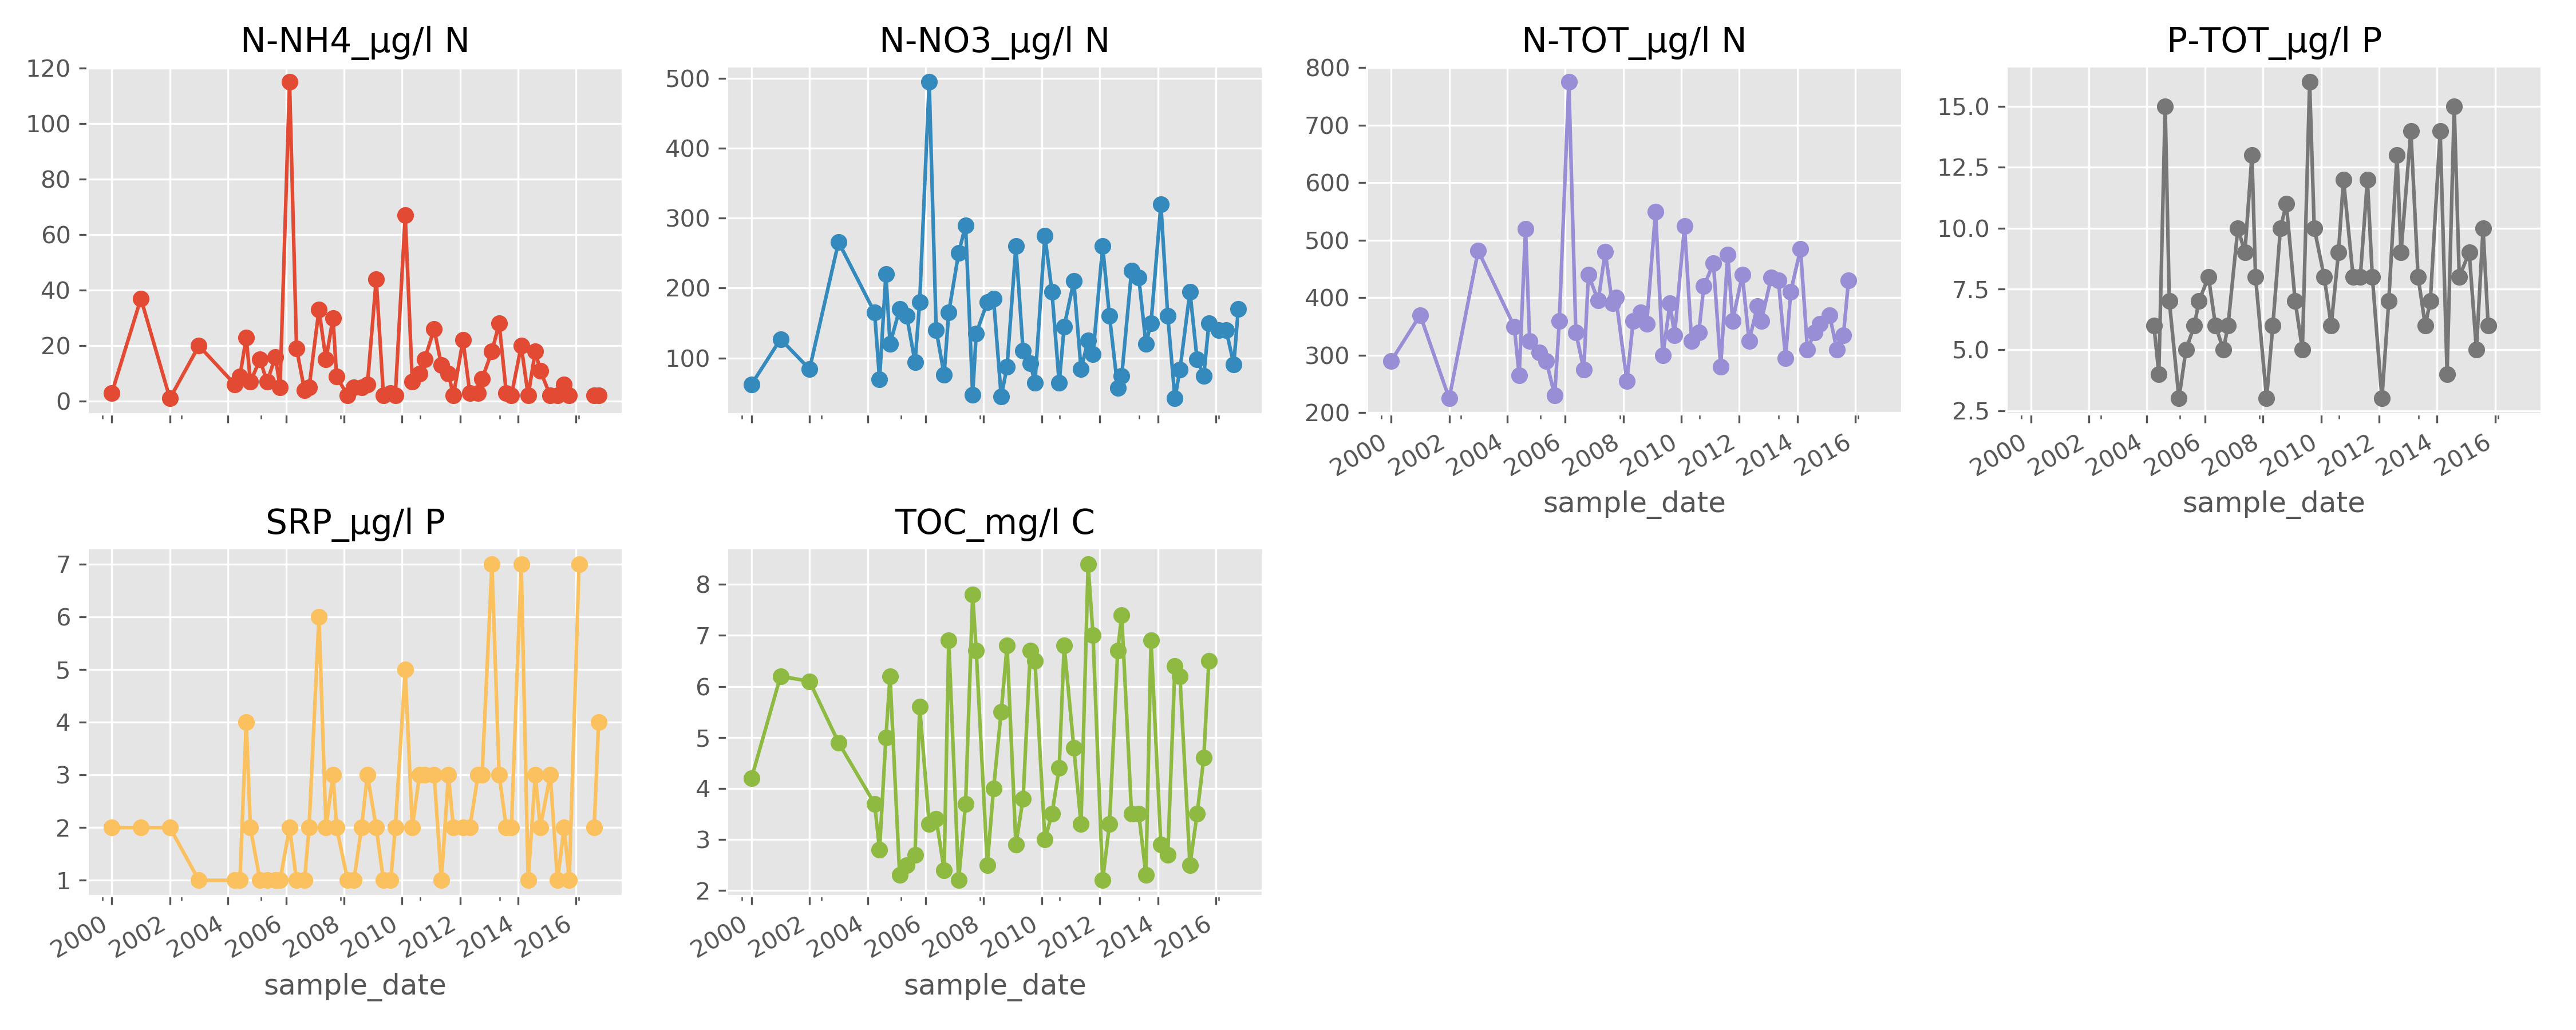

In [8]:
# Show example image
print ('Raw data for vassdragområde %s.' % vass)
Image(png_path)

#### 2.1.5. Simple linear regression against flow

Ultimately, we would like to generate daily resolution time series for the marine models. We have daily flow data for all sites, so one possible option is to consider concentration-discharge plots to see if a relationship existis for predicting concentrations from discharge. In general, such relationships are not straightforward, so I don't expect this to be very successful, but it's worth a go initially. The usual approach is to consider simple OLS regression of $log(C)$ versus $log(Q)$.

As noted above, concentrations for SRP and NH4 are typically close to the limit of detection, so simple OLS regression is not really appropriate. Instead, I will perform concentration-flow regressions for just Tot-N, Tot-P and TOC. If this works, I can also derive regressions (based on all the data pooled together?) between e.g. Tot-N & NH4, and SRP & Tot-P etc. which will probably be more robust than using flow with these parameters directly. This approach has the additional advantage that almost all sites have reasonable Tot-N, Tot-P and TOC records, whereas data for the other chemical parameters is quite limited. Performing site-specific C-Q regressions and aggregated/overall C-C regressions should therefore ensure that each regression has a reasonable amount of data.

The code below creates one matrix plot for Tot-N, Tot-P and TOC at each site. The plots are available [here](https://github.com/JamesSample/martini/tree/master/plots/flow_conc_reg) and an example is shown below.

In [10]:
# Simple OLS regression against flow
for vass in wc_df2['vassnr'].unique():
    # Skip sites with no data
    if vass not in (5, 10):
        # Get stn data
        df = wc_df2.query('vassnr == @vass')
        
        # Set values equal to 0 to NaN (zeros cause log issues, and no lab 
        # method can actually report 0)
        df[df==0] = np.nan

        # Get RESA stn ID
        mar_cd = 'nmca%03d' % vass
        resa_id = riv_df.query('martini_code == @mar_cd')['resa_id'].iloc[0]

        # Get flow data from NIVABASE
        q_df = nivapy.da.extract_resa_discharge(resa_id,
                                                '2000-01-01',
                                                '2017-12-31',
                                                eng,
                                                plot=False)

        # Restructure chem
        df = df.sort_values(['sample_date', 'par_unit'])
        df.set_index(idx_cols, inplace=True)
        df = df.unstack('par_unit').reset_index().sort_values('sample_date')
        df.index = df['sample_date']
        del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
        df.columns = df.columns.get_level_values(1)

        # Get list of chem cols
        if vass == 4:
            # No TOC
            chem_cols = ['N-TOT_µg/l N', 'P-TOT_µg/l P']
        else:
            chem_cols = ['N-TOT_µg/l N', 'P-TOT_µg/l P', 'TOC_mg/l C']

        # Join to Q
        df = df.join(q_df, how='left')

        # Setup plot
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
        axes = axes.flatten()

        # Regression plots for each parameter
        for idx, col in enumerate(chem_cols):
            # Regression plot
            sn.regplot(x=np.log10(df['flow_m3/s']), 
                       y=np.log10(df[col]), 
                       data=df, 
                       ax=axes[idx])
            axes[idx].set_title(col)
            axes[idx].set_xlabel('log[Flow ($m^3/s$)]')
            axes[idx].set_ylabel('log[%s]' % col)

        plt.tight_layout()       

        # Save png
        png_path = r'../plots/flow_conc_reg/vassnr_%03d.png' % vass
        plt.savefig(png_path, dpi=300)
        plt.close()  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


Regression plots for vassdragområde 25.


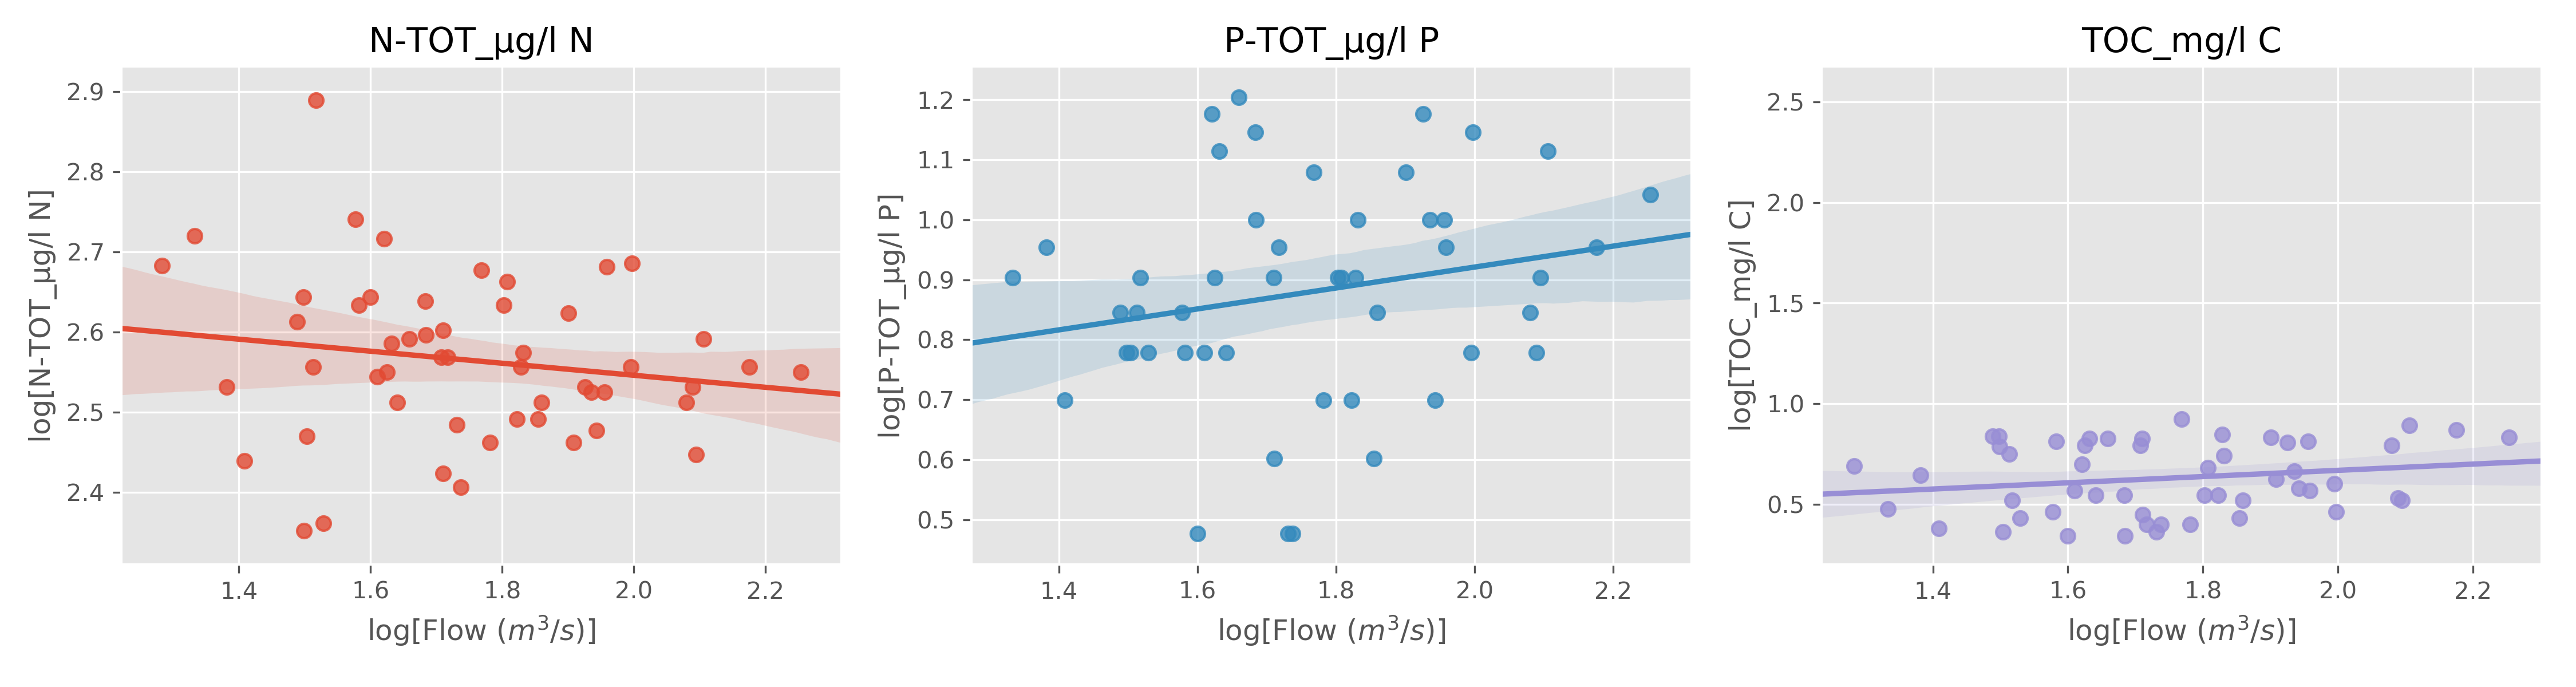

In [11]:
# Show example image
print ('Regression plots for vassdragområde %s.' % vass)
Image(png_path)

In some cases the regression results are poor (as above), but in several examples they're better than expected. If we need to generate daily inputs for the marine models, then I don't think we have any better option than using these equations, as flow is the only variable measured reliably with daily resolution for all the major catchments.

#### 2.1.6. Simple linear regression between concentrations

The code below pools all the data for all 23 sites (22 for C) and derives regression relationships between the following variables

 * NH4 vs. Tot-N
 * NO3 vs. Tot-N
 * SRP vs. Tot-P
 * DOC vs. TOC
 
The C-Q relationships from above can be used to derive daily Tot-N, Tot-P and TOC concentrations from the dishcarge data, and then these relationships can be used to estimate NH4, NO3, SRP and DOC.

Note that the code below filters out one obviously contaminated sample with Tot-P > 3000 ug/l.

In [ ]:
# Restructure chem
df = wc_df2.copy()
df = df.sort_values(['vassnr', 'sample_date', 'par_unit'])
df.set_index(idx_cols, inplace=True)
df = df.unstack('par_unit').reset_index().sort_values(['vassnr', 'sample_date'])
del df['station_name'], df['lon'], df['lat']
df.columns = df.columns.get_level_values(1)
cols = list(df.columns)
cols[:2] = ['vassnr', 'sample_date']
df.columns = cols

# Filter obviously contaminated P sample
df = df[df['P-TOT_µg/l P']<3000]

# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = axes.flatten()

# NH4 vs Tot-N
sn.regplot(x='N-TOT_µg/l N', 
           y='N-NH4_µg/l N', 
           data=df, 
           ax=axes[0])
axes[0].set_xlabel('N-TOT_µg/l N')
axes[0].set_ylabel('N-NH4_µg/l N')
axes[0].set_title('N-NH4')

# NO3 vs Tot-N
sn.regplot(x='N-TOT_µg/l N', 
           y='N-NO3_µg/l N', 
           data=df, 
           ax=axes[1])
axes[1].set_xlabel('N-TOT_µg/l N')
axes[1].set_ylabel('N-NO3_µg/l N')
axes[1].set_title('N-NO3')

# SRP vs Tot-P
sn.regplot(x='P-TOT_µg/l P', 
           y='SRP_µg/l P', 
           data=df, 
           ax=axes[2])
axes[2].set_xlabel('P-TOT_µg/l P')
axes[2].set_ylabel('SRP_µg/l P')
axes[2].set_title('SRP')

# DOC vs TOC
sn.regplot(x='TOC_mg/l C', 
           y='DOC_mg/l C', 
           data=df, 
           ax=axes[3])
axes[3].set_xlabel('TOC_mg/l C')
axes[3].set_ylabel('DOC_mg/l C')
axes[3].set_title('DOC')
axes[3].set_xlim(0,10)
axes[3].set_ylim(0,10)

plt.tight_layout()

The regressions for NO3 and DOC look very good, but those for NH4 and SRP are less convincing. This is partly because values for these parameters are often very close to the detection limit, and partly because the relationships just seem to vary a lot from site to site. I have tried performing these regressions separately for each site and, in some locations, (e.g. Glomma), the SRP relationship is very good - it's the "classic" result of $SRP \approx 0.6*TotP$. However, elsewhere the relationship is either poor or significnatly different. In most cases, we do not have enough data to perform the regressions separately for each site, so I'll continue with the relationships above, even though they are sometimes poor.